We start by adding the necessary folders to the current working path.

In [3]:
# import sys/os
import sys, os

# get current directory
path = os.getcwd()

# get parent directory
parent_directory = os.path.sep.join(path.split(os.path.sep)[:-4])

# add utils folder to current working path
sys.path.append(parent_directory+"/subfunctions/utils")

# add integration folder to current working path
sys.path.append(parent_directory+"/subfunctions/integration")

# add FTLE folder to current working path
sys.path.append(parent_directory+"/demos/AdvectiveBarriers/FTLE3D")

# add ActiveBarriers folder to current working path
sys.path.append(parent_directory+"/demos/ActiveBarriers")

# Overview

We illustrate the numerical implementation and the use of the active Finite Time Lyapunov Exponent ($ \mathrm{aFTLE} $) on a directionally steady Beltrami flow such as the 3D viscous, unsteady version of the classic ABC-flow. The active LCS diagnostic is applied to the three-dimensional and steady instantaneous linear momentum barrier equation. The notebook is structured as follows:

1. Import data stored in the folder 'data/ABC'.
<br />
2. Define computational parameters (such as the number of cores) and data.
 <br />
3. Define spatio-temporal domain.
 <br />
4. Interpolate velocity from (discrete) gridded data.
 <br />
5. Instantaneous linear momentum barrier equation active Finite Time Lyapunov Exponent ($ \mathrm{aFTLE} $):

   <br />
   * For 3D incompressible, uniform-density Navier–Stokes flows, the Eulerian barrier equation for linear momentum is:
   <br />
   \begin{equation*}
   \mathbf{x'}(s) = \nu \rho \Delta \mathbf{v}(\mathbf{x}, t)
   \label{eq: linearmoment1}
   \tag{1}
   \end{equation*}
   
   <br />
   * For 3D incompressible, uniform-density Navier–Stokes flows, the Eulerian barrier equation for vorticity is:
   <br />
   \begin{equation}
   \mathbf{x'}(s) = \nu \rho \Delta \mathbf{\omega}(\mathbf{x}, t)
   \label{eq: vorticity1}
   \end{equation}
    
   It can be verified that the 3D viscous, unsteady version of the classic ABC-flow satisfies the strong Beltrami property:
   <br />
   \begin{equation}
   \mathbf{\omega}(\mathbf{x},t) = \mathbf{v}(\mathbf{x}, t)
   \label{eq: Beltrami}
   \end{equation}
   By definition it follows:
   <br />
   \begin{equation}
   \mathbf{\Delta v}(\mathbf{x},t) = \mathbf{\Delta \omega}(\mathbf{x},t) = \mathbf{\nabla}(\mathbf{ \nabla \omega})-\mathbf{\nabla} \times (\mathbf{\nabla \times \mathbf{\omega}}) = \mathbf{v}(\mathbf{x}, t)
   \label{eq: LaplacianOmega}
   \end{equation}
   
   The Eulerian barrier equation for both linear momentum/vorticity reduce to:
   <br />
   \begin{equation}
   \tag{2}
   \mathbf{x'}(s) = -\nu \rho \mathbf{v}(\mathbf{x}, t)
   \label{eq: linearmoment2}
   \end{equation}
   
   By appropriate rescaling with respect to the dummy time, equation \eqref{eq: linearmoment2} simplifies to: 
   <br />
   \begin{equation}
   \mathbf{x'}(s) = \Delta \mathbf{v}(\mathbf{x}, t) = \Delta \mathbf{\omega}(\mathbf{x}, t) = \mathbf{v}(\mathbf{x}, t)
   \label{eq: linearmoment3}
   \tag{3}
   \end{equation}
   
   In order to compute \eqref{eq: linearmoment3}, we numerically evaluate the Laplacian of the velocity field. Generally the strong Beltrami property of the flow is not know, whenever the data is gathered from numerical/experimental data and hence one needs to compute $ \Delta \mathbf{v}(\mathbf{x}, t) $ in order to evaluate Eulerian active barriers.
   
    Time 't' is just a fixed parameter and hence the system is autonomous and the integration is done with respect to a dummy time variable 's'. 's' can be arbitrarily large and the $ \mathrm{aFTLE} $ is only limited by the spatial resolution and domain. It can thus potentially reveal finer and more resolved structures compared to the classic version of the $ \mathrm{FTLE} $, which is fundamentally limited by the temporal domain of the available data.
    
    <br />
    
   * We start by evaluating the right-hand-side of equation \eqref{eq: linearmoment3} by first interpolating $ \mathbf{v}(\mathbf{x}, t) $ over the spatial meshgrid.
   
   <br />
   
   * We then apply the $ \mathrm{aFTLE} $ to the autonomous ODE from equation \eqref{eq: linearmoment3} over different dummy time-intervals. We additionally compare the results with the classic instantaneous $ \mathrm{FTLE} $-field.
<br />
6. References

# Import data

In [4]:
# import scipy
import scipy.io as sio

# Import velocity data from file in data-folder
mat_file = sio.loadmat('../../../../data/ABC/ABCunsteady.mat')

U = mat_file['u'] # array (NY, NX, NZ)
V = mat_file['v'] # array (NY, NX, NZ)
W = mat_file['w'] # array (NY, NX, NZ)
x = mat_file['x'] # array (1, NX)
y = mat_file['y'] # array (1, NY)
z = mat_file['z'] # array (1, NZ)
time_data = mat_file['t']

# Computational parameters and data

Here we define the computational parameters and the data.

In [5]:
# import numpy
import numpy as np

# Number of cores for parallel computing
Ncores = 4 # int

# Periodic boundary conditions
periodic_x = True # bool
periodic_y = True # bool
periodic_z = True # bool
periodic = [periodic_x, periodic_y, periodic_z]

# Unsteady velocity field
bool_unsteady = True # bool

# Defined domain
defined_domain = np.isfinite(U).astype(int) # array (NY, NX, NZ)

## Compute meshgrid of dataset
X, Y, Z = np.meshgrid(x, y, z) # array (NY, NX), array (NY, NX, NZ)

## Resolution of meshgrid
dx_data = X[0,1,0]-X[0,0,0] # float
dy_data = Y[1,0,0]-Y[0,0,0] # float
dz_data = Y[0,0,1]-Z[0,0,0] # float

delta = [dx_data, dy_data, dx_data] # list (3, )

# Spatio-temporal domain

Here we define the spatio-temporal domain over which to consider the dynamical system.

In [6]:
# Time
t0 = 0 # float

# boundaries
xmin = 0 # float
xmax = 2*np.pi # float
ymin = 0 # float
ymax = 2*np.pi # float
zmin = 0 # float
zmax = 2*np.pi # float

# Resolution of meshgrid
Ny = 200 # int
Nx = 200 # int
Nz = 200 # int

x_domain = np.linspace(xmin, xmax, Nx, endpoint = True) # array (Nx, )
y_domain = np.linspace(ymin, ymax, Ny, endpoint = True) # array (Ny, )
z_domain = np.linspace(zmin, zmax, Nz, endpoint = True) # array (Nz, )

dx = x_domain[1]-x_domain[0] # float
dy = y_domain[1]-y_domain[0] # float
dz = z_domain[1]-z_domain[0] # float

X_domain, Y_domain, Z_domain = np.meshgrid(x_domain, y_domain, z_domain) # array (Ny, Nx, Nz)

# Define dummy time-intervals for computation of aFTLE in ascending order
s1 = 10 # float s1 > 0
s2 = 30 # float s2 > s1
s3 = 50 # float s3 > s2

s = [s1, s2, s3] # list (3,)

# define dummy time interval
ds = 0.1
sN = s[-1] # Feel free to change this parameter as needed
s_dummy = np.arange(0, sN+ds, ds)

# auxiliary grid spacing
aux_grid = [0.1*dx, 0.1*dy, 0.1*dz] # list (3,)

# Interpolate velocity and Laplacian of velocity

In order to evaluate the velocity field at arbitrary locations, we interpolate the discrete velocity data. The interpolation with respect to time and space is "linear".
We further compute the Laplacian of the velocity field and construct an interpolation object for the laplacian of the velocity field.

In [7]:
# Import interpolation function for unsteady flow field
from ipynb.fs.defs.Interpolant import interpolant_unsteady, interpolant_steady

# Import function to compute laplacian of velocity from structured velocity data.
from ipynb.fs.defs.laplacian_velocity import laplacian_velocity

# Interpolate velocity data using cubic spatial interpolation
Interpolant = interpolant_unsteady(X, Y, Z, U, V, W, time_data)

Interpolant_u = Interpolant[0] # RectangularBivariateSpline-object
Interpolant_v = Interpolant[1] # RectangularBivariateSpline-object
Interpolant_w = Interpolant[2] # RectangularBivariateSpline-object

# Compute laplacian of velocity
Lap_u, Lap_v, Lap_w  = laplacian_velocity(t0, X, Y, Z, U, V, W, periodic, bool_unsteady, 0, time_data)

# Set nan values to zero (in case there are any) so that we can apply interpolant. 
# Interpolant does not work if the array contains nan values. 
Lap_u[np.isnan(Lap_u)] = 0
Lap_v[np.isnan(Lap_v)] = 0
Lap_w[np.isnan(Lap_w)] = 0

# Interpolate laplacian of velocity data using cubic spatial interpolation
Interpolant_lap = interpolant_steady(X, Y, Z, Lap_u, Lap_v, Lap_w)

Interpolant_lap_u = Interpolant_lap[0] # RectangularBivariateSpline-object
Interpolant_lap_v = Interpolant_lap[1] # RectangularBivariateSpline-object
Interpolant_lap_w = Interpolant_lap[2] # RectangularBivariateSpline-object

Compute 1st order spatial derivative...
Compute 2nd order spatial derivative...


# Instantaneous linear momentum/vorticity barriers from active $ \mathrm{aFTLE} $

We visualize linear momentum/vorticity barriers by applying the $ \mathrm{FTLE} $ to trajectories of instantaneous linear momentum/vorticity barrier equation \ref{eq: linearmoment3}. As soon as the $ \mathrm{FTLE} $-field is applied to an active vector field, such as linear momentum (or vorticity), we refer to it as $ \mathrm{aFTLE} $ (active $ \mathrm{FTLE} $). We subsequently compare the results with the classic version of the instantaneous $ \mathrm{FTLE} $-field which is given by the maximum eigenvalue of the rate of strain tensor.

## active FTLE

We now compute the active $ \mathrm{FTLE} $ for the instantaneous linear momentum/vorticity barrier equations. First, we evaluate the gradient of the active flow map over the meshgrid. The active flow map is given by the solution of the autonomous ODE from equation \ref{eq: linearmoment3}. Finally, we apply the classic $ \mathrm{FTLE} $ to the gradient of the active flow map. The computation of the active $ \mathrm{FTLE} $ is not done over the 3D meshgrid but only over the 2D faces of the cube $ [0,2\pi]^3 $.

In [8]:
# Import function to compute gradient of flow map
from ipynb.fs.defs.gradient_flowmap import gradient_flowmap

# Import function to compute finite time Lyapunov exponent (FTLE)
from ipynb.fs.defs.FTLE import _FTLE

# Import package for parallel computing
from joblib import Parallel, delayed

def compute_aFTLE(x0, y0, z0, s_dummy, s):
    
    X0 = np.array([x0, y0, z0]) # array (3, Nx*Ny*Nz)
    
    activeDF = gradient_flowmap(s_dummy, X0, X, Y, Z, Interpolant_lap_u, Interpolant_lap_v, Interpolant_lap_w, periodic, False, aux_grid) # array (Nt, 3, 3, Nx*Ny*Nz)
    
    aFTLE = np.zeros((len(s), activeDF.shape[-1]))
    
    counter = 0
    for idx in np.searchsorted(s_dummy, s):
        
        for i in range(activeDF.shape[3]):
            
            aFTLE[counter, i] = _FTLE(activeDF[idx,:,:,i], s_dummy[idx])
            
        counter += 1
    
    return aFTLE

# Split x0,y0,z0 into 'Ncores' equal batches for parallel computing
def split(a, n):
    k, m = divmod(len(a), n)
    return (a[i*k+min(i, m):(i+1)*k+min(i+1, m)] for i in range(n))

### XY-plane

In [9]:
# Vectorize initial conditions by arranging them to a vector of size (Nx*Ny*Nz, )
x0_xy = X_domain[:,:,-1].ravel() # array (Nx*Ny, )
y0_xy = Y_domain[:,:,-1].ravel() # array (Nx*Ny, )
z0_xy = Z_domain[:,:,-1].ravel() # array (Nx*Ny, )

x0_batch = list(split(x0_xy, Ncores)) # list (Nx*Ny)
y0_batch = list(split(y0_xy, Ncores)) # list (Nx*Ny)
z0_batch = list(split(z0_xy, Ncores)) # list (Nx*Ny)
results = Parallel(n_jobs=Ncores, verbose = 2)(delayed(compute_aFTLE)(x0_batch[i], y0_batch[i], z0_batch[i], s_dummy, s) for i in range(len(x0_batch)))

# Extract results of aFTLE computation on xy-plane
aFTLE_xy = results[0]
for res in results[1:]:
    aFTLE_xy = np.append(aFTLE_xy, res, axis = -1)
    
X0_xy = np.array(x0_xy).reshape(Ny,Nx) # array (Ny, Nx)
Y0_xy = np.array(y0_xy).reshape(Ny,Nx) # array (Ny, Nx)
Z0_xy = np.array(z0_xy).reshape(Ny,Nx) # array (Ny, Nx)
aFTLE_xy = np.array(aFTLE_xy).reshape(len(s),Ny,Nx) # array (3, Ny, Nx)

[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done   2 out of   7 | elapsed:  1.1min remaining:  2.9min
[Parallel(n_jobs=7)]: Done   7 out of   7 | elapsed:  1.2min finished


### XZ-plane

In [10]:
# Vectorize initial conditions by arranging them to a vector of size (Nx*Ny*Nz, )
x0_xz = X_domain[0,:,:].ravel() # array (Nx*Nz, )
y0_xz = Y_domain[0,:,:].ravel() # array (Nx*Nz, )
z0_xz = Z_domain[0,:,:].ravel() # array (Nx*Nz, )

x0_batch = list(split(x0_xz, Ncores)) # list (Nx*Nz)
y0_batch = list(split(y0_xz, Ncores)) # list (Nx*Nz)
z0_batch = list(split(z0_xz, Ncores)) # list (Nx*Nz)
results = Parallel(n_jobs=Ncores, verbose = 2)(delayed(compute_aFTLE)(x0_batch[i], y0_batch[i], z0_batch[i], s_dummy, s) for i in range(len(x0_batch)))

# Extract results of aFTLE computation on xz-plane
aFTLE_xz = results[0]
for res in results[1:]:
    aFTLE_xz = np.append(aFTLE_xz, res, axis = -1)
    
X0_xz = np.array(x0_xz).reshape(Nz,Nx) # array (Ny, Nx)
Y0_xz = np.array(y0_xz).reshape(Nz,Nx) # array (Ny, Nx)
Z0_xz = np.array(z0_xz).reshape(Nz,Nx) # array (Ny, Nx)
aFTLE_xz = np.array(aFTLE_xz).reshape(len(s),Nz,Nx) # array (3, Ny, Nx)

[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done   2 out of   7 | elapsed:  1.1min remaining:  2.8min
[Parallel(n_jobs=7)]: Done   7 out of   7 | elapsed:  1.2min finished


### YZ-plane

In [11]:
# Vectorize initial conditions by arranging them to a vector of size (Nx*Ny*Nz, )
x0_yz = X_domain[:,0,:].ravel() # array (Ny*Nz, )
y0_yz = Y_domain[:,0,:].ravel() # array (Ny*Nz, )
z0_yz = Z_domain[:,0,:].ravel() # array (Ny*Nz, )

x0_batch = list(split(x0_yz, Ncores)) # list (Ny*Nz)
y0_batch = list(split(y0_yz, Ncores)) # list (Ny*Nz)
z0_batch = list(split(z0_yz, Ncores)) # list (Ny*Nz)
results = Parallel(n_jobs=Ncores, verbose = 2)(delayed(compute_aFTLE)(x0_batch[i], y0_batch[i], z0_batch[i], s_dummy, s) for i in range(len(x0_batch)))

# Extract results of aFTLE computation on xz-plane
aFTLE_yz = results[0]
for res in results[1:]:
    aFTLE_yz = np.append(aFTLE_yz, res, axis = -1)
    
X0_yz = np.array(x0_yz).reshape(Nz,Ny) # array (Nz, Ny) 
Y0_yz = np.array(y0_yz).reshape(Nz,Ny) # array (Nz, Ny) 
Z0_yz = np.array(z0_yz).reshape(Nz,Ny) # array (Nz, Ny) 
aFTLE_yz = np.array(aFTLE_yz).reshape(len(s),Nz,Ny) # array (3, Nz, Ny)

[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done   2 out of   7 | elapsed:  1.1min remaining:  2.8min
[Parallel(n_jobs=7)]: Done   7 out of   7 | elapsed:  1.2min finished


##### aFTLE over different dummy time-intervals

In the following we visualize the instantaneous linear momentum/vorticity barriers at time $ t_0 = 0 $ through the $ \mathrm{aFTLE} $ over different dummy time-intervals. Ridges of $ \mathrm{aFTLE}_{0,0}^{s_i} \ (i \in \lbrace 1,2,3 \rbrace) $ indicate transport barriers which block the transport of linear momentum. Note that contrary to the classic $ \mathrm{FTLE} $, the $ \mathrm{aFTLE} $ diagnostic is not limited by the temporal domain as the dummy time-interval can be chosen to be arbitrarily large. We explore the structures of the $ \mathrm{aFTLE}_{0,t_0}^{s_i} $ over different dummy time-intervals $ s_i \in \lbrace 1,2,3 \rbrace $ at time $ t_0 $.

In [ ]:
# Import plotly for 3D figures
from plotly import graph_objs as go

# iterate over different dummy time-intervals and display aFTLE field calculated over each time-interval

def plot_aFTLE(i):

    # define minimum and maximum values for colorbar
    min_value = min(np.min(aFTLE_yz[i,:,:]),min(np.min(aFTLE_xy[i,:,:]), np.min(aFTLE_xz[i,:,:])))
    max_value = max(np.max(aFTLE_yz[i,:,:]),max(np.max(aFTLE_xy[i,:,:]), np.max(aFTLE_xz[i,:,:])))

    # create figure
    fig = go.Figure(data=[go.Surface(x = X0_xy, y = Y0_xy, z = Z0_xy, surfacecolor = aFTLE_xy[i,:,:], showscale = True, colorscale='rainbow', cmin=min_value, cmax=max_value)])
    fig.add_trace(go.Surface(x = X0_xz, y = Y0_xz, z = Z0_xz, surfacecolor = aFTLE_xz[i,:,:], showscale = False, colorscale='rainbow', cmin=min_value, cmax=max_value))
    fig.add_trace(go.Surface(x = X0_yz, y = Y0_yz, z = Z0_yz, surfacecolor = aFTLE_yz[i,:,:], showscale = False, colorscale='rainbow', cmin=min_value, cmax=max_value))
    fig.add_trace(go.Surface(x = X0_xy, y = Y0_xy, z = Z0_xy-2*np.pi, surfacecolor = aFTLE_xy[i,:,:], showscale = False, colorscale='rainbow', cmin=min_value, cmax=max_value))
    fig.add_trace(go.Surface(x = X0_xz, y = Y0_xz+2*np.pi, z = Z0_xz, surfacecolor = aFTLE_xz[i,:,:], showscale = False, colorscale='rainbow', cmin=min_value, cmax=max_value))
    fig.add_trace(go.Surface(x = X0_yz+2*np.pi, y = Y0_yz, z = Z0_yz, surfacecolor = aFTLE_yz[i,:,:], showscale = False, colorscale='rainbow', cmin=min_value, cmax=max_value))

    # camera
    camera = dict(eye=dict(x=-1.45,y=-1.45,z=1.7))
    
    fig.update_layout(scene_camera=camera)
    
    fig.update_layout(
    title={
        'text': f'$\mathrm{{aFTLE}}_{{{0,t0}}}^{{{s[i]}}}$',
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})

    fig.show()

##### $ \mathrm{aFTLE}_{0, t_0}^{s_1} $

Instantaneous linear momentum/vorticity barriers at time $ t_0 = 0 $ from $ \mathrm{aFTLE}_{0, t_0}^{s_1} $. 

__Note__ The fields can be visualized using the function ```plot_aFTLE``` which renders 3D plotly figures. Since these consume a lot of memory, we simply plot the 2D sections here. 

In [ ]:
################################################ PLOT RESULTS ################################################
plot_aFTLE(0)

In [13]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, '$x=0$ section')

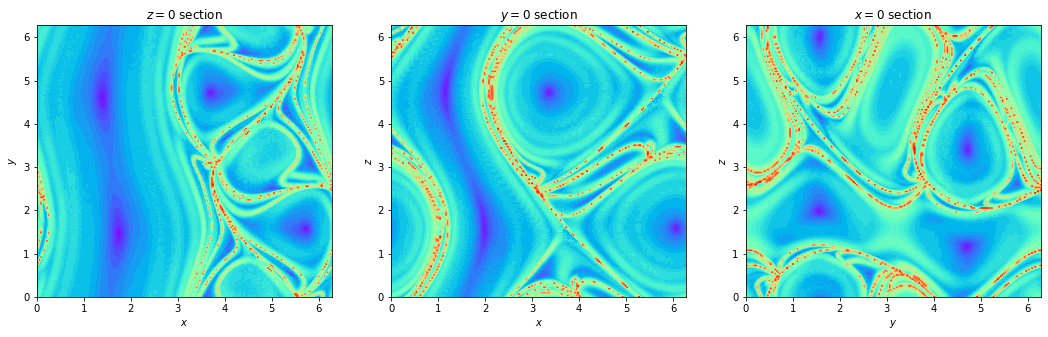

In [36]:
f,axes = plt.subplots(ncols = 3, nrows = 1, figsize = (18, 5))
cmapToUse = 'rainbow'
nContours = 40
sIndex = 0
axes[0].contourf(x_domain, y_domain, aFTLE_xy[sIndex,:,:], nContours,  cmap = cmapToUse)
axes[0].set_xlabel('$x$')
axes[0].set_ylabel('$y$')
axes[0].set_title('$z=0$ section')

axes[1].contourf(x_domain, z_domain, aFTLE_xz[sIndex,:,:], nContours,  cmap = cmapToUse)
axes[1].set_xlabel('$x$')
axes[1].set_ylabel('$z$')
axes[1].set_title('$y=0$ section')


axes[2].contourf(y_domain, z_domain, aFTLE_yz[sIndex,:,:], nContours,  cmap = cmapToUse)
axes[2].set_xlabel('$y$')
axes[2].set_ylabel('$z$')
axes[2].set_title('$x=0$ section')

##### $ \mathrm{aFTLE}_{0, t_0}^{s_2} $

Instantaneous linear momentum barriers/vorticity at time $ t_0 = 0 $ from $ \mathrm{aFTLE}_{0, t_0}^{s_2} $.

In [ ]:
################################################ PLOT RESULTS ################################################
plot_aFTLE(1)

Text(0.5, 1.0, '$x=0$ section')

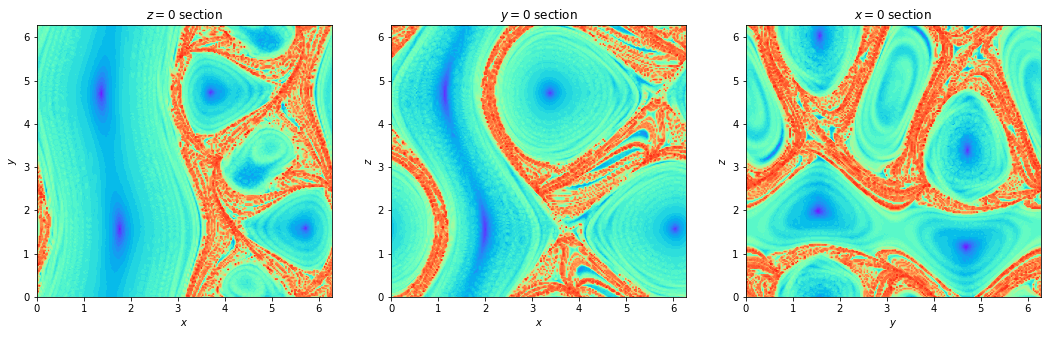

In [37]:
f,axes = plt.subplots(ncols = 3, nrows = 1, figsize = (18, 5))
cmapToUse = 'rainbow'
nContours = 40
sIndex = 1
axes[0].contourf(x_domain, y_domain, aFTLE_xy[sIndex,:,:], nContours,  cmap = cmapToUse)
axes[0].set_xlabel('$x$')
axes[0].set_ylabel('$y$')
axes[0].set_title('$z=0$ section')

axes[1].contourf(x_domain, z_domain, aFTLE_xz[sIndex,:,:], nContours,  cmap = cmapToUse)
axes[1].set_xlabel('$x$')
axes[1].set_ylabel('$z$')
axes[1].set_title('$y=0$ section')


axes[2].contourf(y_domain, z_domain, aFTLE_yz[sIndex,:,:], nContours,  cmap = cmapToUse)
axes[2].set_xlabel('$y$')
axes[2].set_ylabel('$z$')
axes[2].set_title('$x=0$ section')

##### $ \mathrm{aFTLE}_{0, t_0}^{s_3} $

Instantaneous linear momentum barriers/vorticity at time $ t_0 = 0 $ from $ \mathrm{aFTLE}_{0, t_0}^{s_23} $.

In [ ]:
################################################ PLOT RESULTS ################################################
plot_aFTLE(2)

Text(0.5, 1.0, '$x=0$ section')

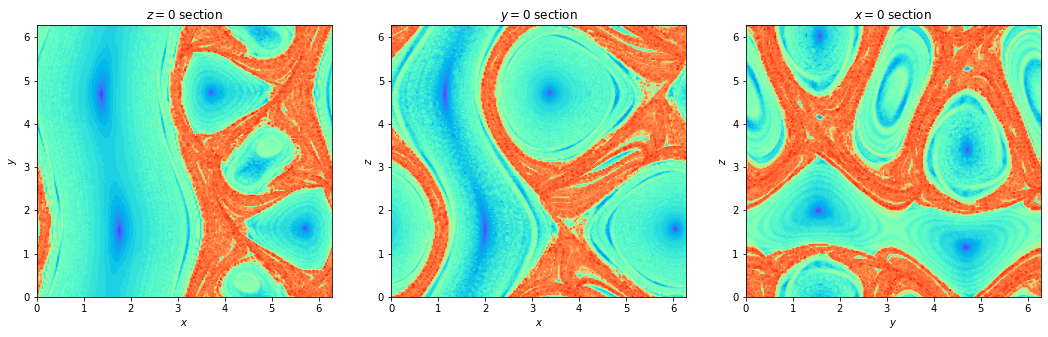

In [38]:
f,axes = plt.subplots(ncols = 3, nrows = 1, figsize = (18, 5))
cmapToUse = 'rainbow'
nContours = 40
sIndex = 2
axes[0].contourf(x_domain, y_domain, aFTLE_xy[sIndex,:,:], nContours,  cmap = cmapToUse)
axes[0].set_xlabel('$x$')
axes[0].set_ylabel('$y$')
axes[0].set_title('$z=0$ section')

axes[1].contourf(x_domain, z_domain, aFTLE_xz[sIndex,:,:], nContours,  cmap = cmapToUse)
axes[1].set_xlabel('$x$')
axes[1].set_ylabel('$z$')
axes[1].set_title('$y=0$ section')


axes[2].contourf(y_domain, z_domain, aFTLE_yz[sIndex,:,:], nContours,  cmap = cmapToUse)
axes[2].set_xlabel('$y$')
axes[2].set_ylabel('$z$')
axes[2].set_title('$x=0$ section')

## Instantaneous FTLE

The instananeous (classic) $ \mathrm{FTLE} $-field at time 't' is given by the maximum eigenvalue of the rate of strain tensor. The rate of strain tensor is computed from the gradient of the velocity field at time 't':

\begin{equation}
\mathbf{S}(\mathbf{x}, t) = \dfrac{1}{2}(\mathbf{\nabla v}(\mathbf{x}, t)+\mathbf{\nabla v}(\mathbf{x}, t)^T)
\end{equation}

The rate of strain tensor $ S(\mathbf{x}, t) $ at time $ t $ is computed by iterating over meshgrid. $ (\mathbf{x}, t) $ is computed from the gradient of the velocity field by using an auxiliary meshgrid.

In [39]:
# Import function to compute gradient of velocity function
from ipynb.fs.defs.gradient_velocity import gradient_velocity

def parallel_S(x0_batch, y0_batch, z0_batch):
    
    # Initial conditions
    X0 = np.array([x0_batch, y0_batch, z0_batch])
    
    # Compute gradient of velocity field
    grad_vel = gradient_velocity(t0, X0, X, Y, Z, Interpolant_u, Interpolant_v, Interpolant_w, periodic, bool_unsteady, aux_grid) # (3,3,Nx*Ny*Nz)
    
    # Compute rate of strain tensor
    S = .5*(grad_vel+grad_vel.transpose(1,0,2))

    return S

### Instantaneous FTLE on XY-plane

In [40]:
# Import function to compute eigenvalues/eigenvectors
from ipynb.fs.defs.eigen import eigen

# Vectorize initial conditions by arranging them to a vector of size (Nx*Ny*Nz, 3)
x0_xy = X_domain[:,:,0].ravel()
y0_xy = Y_domain[:,:,0].ravel()
z0_xy = Z_domain[:,:,0].ravel()

x0_batch = list(split(x0_xy, Ncores)) # list (Nx*Ny*Nz)
y0_batch = list(split(y0_xy, Ncores)) # list (Nx*Ny*Nz)
z0_batch = list(split(z0_xy, Ncores)) # list (Nx*Ny*Nz)

results = Parallel(n_jobs=Ncores, verbose = 0)(delayed(parallel_S)(x0_batch[i], y0_batch[i], z0_batch[i]) for i in range(len(x0_batch)))

# Extract rate of strain tensor from results of parallel computation
S_xy = results[0]

for res in results[1:]:
    
    S_xy = np.append(S_xy, res, axis = 2)
    
# Reshape array from vectorized form to structured meshgrid
S_xy = S_xy.reshape((3, 3, X_domain.shape[0], X_domain.shape[1]))

inst_FTLE_xy = np.zeros(X_domain[:,:,0].shape)

# iterate over meshgrid
for i in range(X_domain.shape[0]):
    
    for j in range(Y_domain.shape[1]):       
        
        inst_FTLE_xy[i, j] = eigen(S_xy[:,:, i, j])[0][0]

### Instantaneous FTLE on XZ-plane

In [41]:
# Import function to compute eigenvalues/eigenvectors
from ipynb.fs.defs.eigen import eigen

# Vectorize initial conditions by arranging them to a vector of size (Nx*Ny*Nz, 3)
x0_xz = X_domain[0,:,:].ravel()
y0_xz = Y_domain[0,:,:].ravel()
z0_xz = Z_domain[0,:,:].ravel()

x0_batch = list(split(x0_xz, Ncores)) # list (Nx*Ny*Nz)
y0_batch = list(split(y0_xz, Ncores)) # list (Nx*Ny*Nz)
z0_batch = list(split(z0_xz, Ncores)) # list (Nx*Ny*Nz)

results = Parallel(n_jobs=Ncores, verbose = 0)(delayed(parallel_S)(x0_batch[i], y0_batch[i], z0_batch[i]) for i in range(len(x0_batch)))

# Extract rate of strain tensor from results of parallel computation
S_xz = results[0]

for res in results[1:]:
    
    S_xz = np.append(S_xz, res, axis = 2)
    
# Reshape array from vectorized form to structured meshgrid
S_xz = S_xz.reshape((3, 3, X_domain.shape[2], X_domain.shape[1]))

inst_FTLE_xz = np.zeros(X_domain[:,:,0].shape)

# iterate over meshgrid
for i in range(X_domain.shape[2]):
    
    for j in range(Y_domain.shape[1]):       
        
        inst_FTLE_xz[i, j] = eigen(S_xz[:,:, i, j])[0][0]

### Instantaneous FTLE on YZ-plane

In [42]:
# Import function to compute eigenvalues/eigenvectors
from ipynb.fs.defs.eigen import eigen

# Vectorize initial conditions by arranging them to a vector of size (Nx*Ny*Nz, 3)
x0_yz = X_domain[:,0,:].ravel()
y0_yz = Y_domain[:,0,:].ravel()
z0_yz = Z_domain[:,0,:].ravel()

x0_batch = list(split(x0_yz, Ncores)) # list (Nx*Ny*Nz)
y0_batch = list(split(y0_yz, Ncores)) # list (Nx*Ny*Nz)
z0_batch = list(split(z0_yz, Ncores)) # list (Nx*Ny*Nz)

results = Parallel(n_jobs=Ncores, verbose = 0)(delayed(parallel_S)(x0_batch[i], y0_batch[i], z0_batch[i]) for i in range(len(x0_batch)))

# Extract rate of strain tensor from results of parallel computation
S_yz = results[0]

for res in results[1:]:
    
    S_yz = np.append(S_yz, res, axis = 2)
    
# Reshape array from vectorized form to structured meshgrid
S_yz = S_yz.reshape((3, 3, X_domain.shape[1], X_domain.shape[2]))

inst_FTLE_yz = np.zeros(X_domain[:,0,:].shape)

# iterate over meshgrid
for i in range(X_domain.shape[1]):
    
    for j in range(Y_domain.shape[2]):       
        
        inst_FTLE_yz[i, j] = eigen(S_yz[:,:,i, j])[0][0]

The following cell visualizes the instantaneous FTLE computation wiht a 3D plotly figure. 

In [ ]:
################################################ PLOT RESULTS ################################################

# define minimum and maximum values for colorbar
min_value = min(np.min(inst_FTLE_yz),min(np.min(inst_FTLE_xz), np.min(inst_FTLE_xy)))
max_value = max(np.max(inst_FTLE_yz),min(np.max(inst_FTLE_xz), np.max(inst_FTLE_xy)))

# create figure
fig = go.Figure(data=[go.Surface(x = X0_xy, y = Y0_xy, z = Z0_xy, surfacecolor = inst_FTLE_xy, showscale = True, colorscale='rainbow', cmin=min_value, cmax=max_value)])
fig.add_trace(go.Surface(x = X0_xz, y = Y0_xz, z = Z0_xz, surfacecolor = inst_FTLE_xz, showscale = False, colorscale='rainbow', cmin=min_value, cmax=max_value))
fig.add_trace(go.Surface(x = X0_yz, y = Y0_yz, z = Z0_yz, surfacecolor = inst_FTLE_yz, showscale = False, colorscale='rainbow', cmin=min_value, cmax=max_value))
fig.add_trace(go.Surface(x = X0_xy, y = Y0_xy, z = Z0_xy-2*np.pi, surfacecolor = inst_FTLE_xy, showscale = False, colorscale='rainbow', cmin=min_value, cmax=max_value))
fig.add_trace(go.Surface(x = X0_xz, y = Y0_xz+2*np.pi, z = Z0_xz, surfacecolor = inst_FTLE_xz, showscale = False, colorscale='rainbow', cmin=min_value, cmax=max_value))
fig.add_trace(go.Surface(x = X0_yz+2*np.pi, y = Y0_yz, z = Z0_yz, surfacecolor = inst_FTLE_yz, showscale = False, colorscale='rainbow', cmin=min_value, cmax=max_value))

# camera
camera = dict(eye=dict(x=-1.45,y=-1.45,z=1.7))
fig.update_layout(scene_camera=camera)

fig.update_layout(title={
        'text': f'$\mathrm{{instFTLE}}(t_0 = {t0})$',
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})

fig.show()

Here we show the same in 2D sections 

Text(0.5, 1.0, '$x=0$ section')

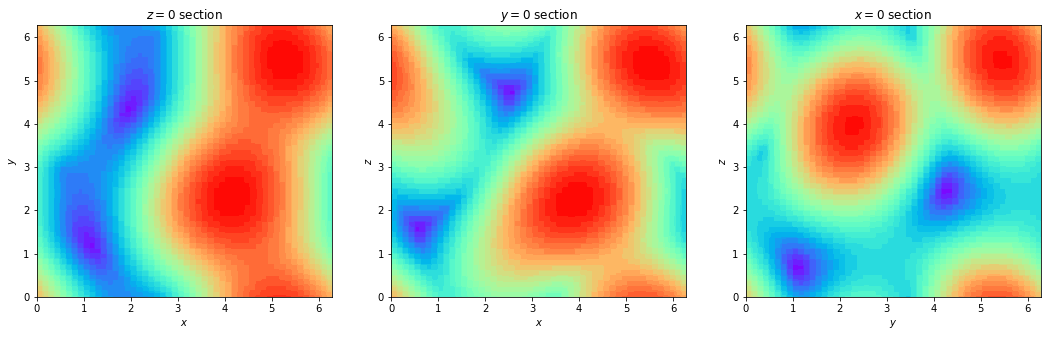

In [46]:
f,axes = plt.subplots(ncols = 3, nrows = 1, figsize = (18, 5))
cmapToUse = 'rainbow'
nContours = 40
sIndex = 1
axes[0].contourf(x_domain, y_domain, inst_FTLE_xy, nContours,  cmap = cmapToUse)
axes[0].set_xlabel('$x$')
axes[0].set_ylabel('$y$')
axes[0].set_title('$z=0$ section')

axes[1].contourf(x_domain, z_domain, inst_FTLE_xz, nContours,  cmap = cmapToUse)
axes[1].set_xlabel('$x$')
axes[1].set_ylabel('$z$')
axes[1].set_title('$y=0$ section')


axes[2].contourf(y_domain, z_domain, inst_FTLE_yz, nContours,  cmap = cmapToUse)
axes[2].set_xlabel('$y$')
axes[2].set_ylabel('$z$')
axes[2].set_title('$x=0$ section')

The figures focus on momentum/vorticity-based active barriers of the 3D viscous, unsteady ABC-flow. 
As expected the $ \mathrm{FTLE} $ has a very weak signature when considering the instantaneous limit. On the other hand, the $ \mathrm{aFTLE} $ provides a clear picture of the main vortices and active hyperbolic barriers. The features become even more pronounced for longer s-times. None of these vortices and hyperbolic features are present in the classic instantaneous $ \mathrm{FTLE} $. Ridges of the $ \mathrm{FTLE} $ reveal barriers which block the transport of linear momentum/vorticity. The equivalence between instantaneous momentum and vorticity barriers holds as the ABC-flows satisfies the strong Beltrami property.

# References

[1] Haller, G., Katsanoulis, S., Holzner, M., Frohnapfel, B., & Gatti, D. (2020). Objective barriers to the transport of dynamically active vector fields. Journal of Fluid Mechanics, 905.

[2] Notebook 9.7.2. in "Transport Barriers and Coherent Structures in Flow Data" by Prof. George Haller.